In [13]:
import cv2 as cv
import numpy as np
import inspect
import copy
from matplotlib import pyplot as plt
from utils import Splitter
import math
from numpy import uint8

TEST_IMG = "test.jpeg"

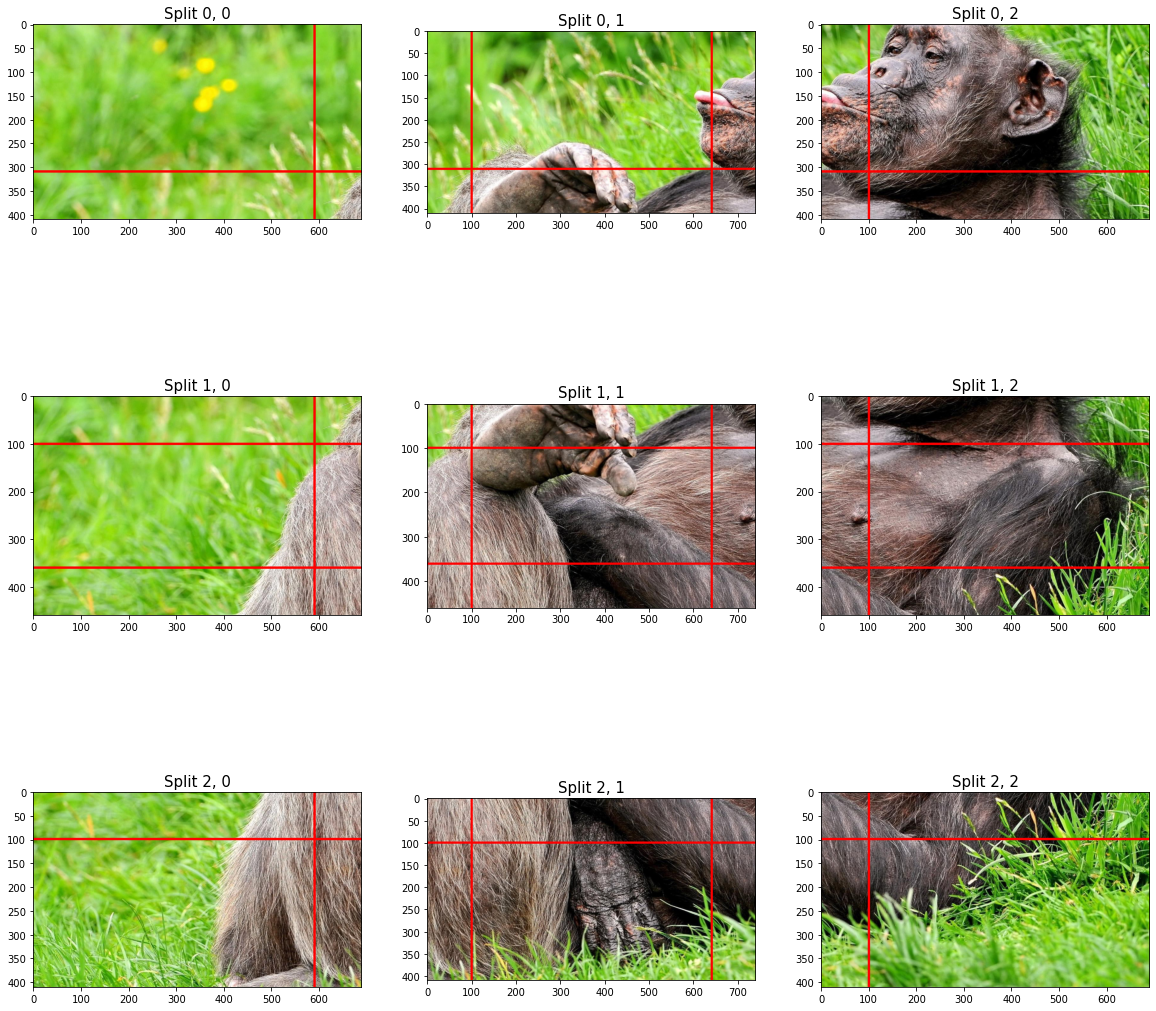

In [14]:
src = cv.imread(TEST_IMG)
if src is None:
    print('Could not open or find the image:', TEST_IMG)
    exit(0)

img = src.copy()
r_split, c_split, split_size = 3, 3, 100
splits = Splitter(img, r_split, c_split, split_size)
splits.show(draw=True)

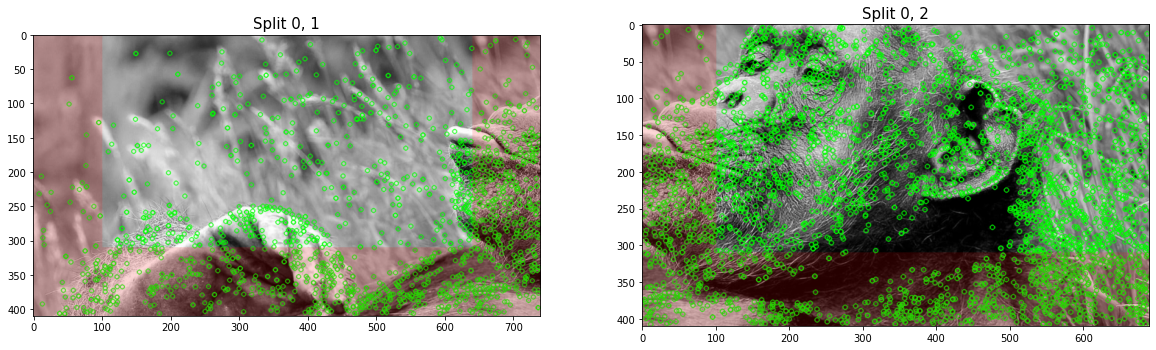

In [15]:
def apply_SIFT(img, min_s=0, flags=cv.DrawMatchesFlags_DEFAULT):
    sift = cv.SIFT_create()
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    kp, des = sift.detectAndCompute(gray, None)
    kp_des = [v for v in zip(kp, des) if v[0].size >= min_s]
    # [(k, d),(k, d)]
    [kp, des] = zip(*kp_des)
    img = cv.drawKeypoints(
        gray, kp, img, color=(0, 255, 0),
        flags=flags
    )

    return img, (kp, np.array(des))

splits.restore()
params = {
    "rrows":range(0, 1),
    "rcols":range(1, 3),
    "draw":True,
    "_rects":True,
    "_alpha":0.15,
    "cmap":"gray",
    "mod":True
}

sift_data = splits.apply_and_show(apply_SIFT, **params)

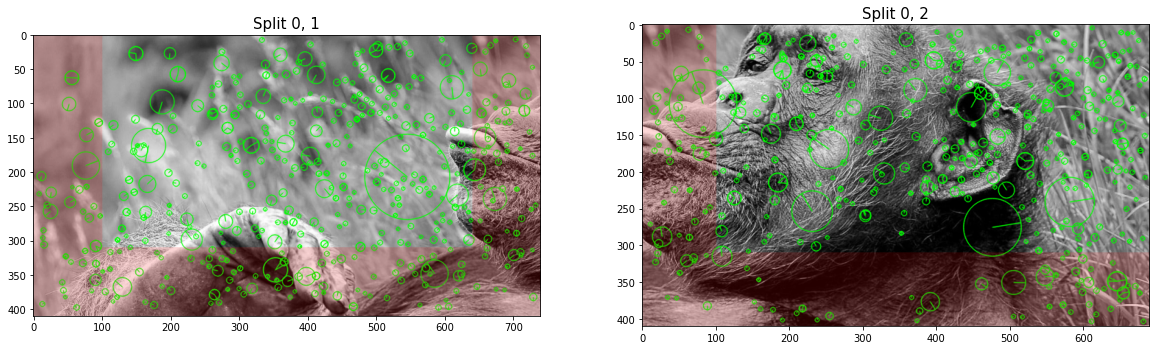

In [16]:
splits.restore()
sift_data = splits.apply_and_show(
    apply_SIFT,
    **params,
    flags=cv.DrawMatchesFlags_DRAW_RICH_KEYPOINTS,
    min_s=5
)

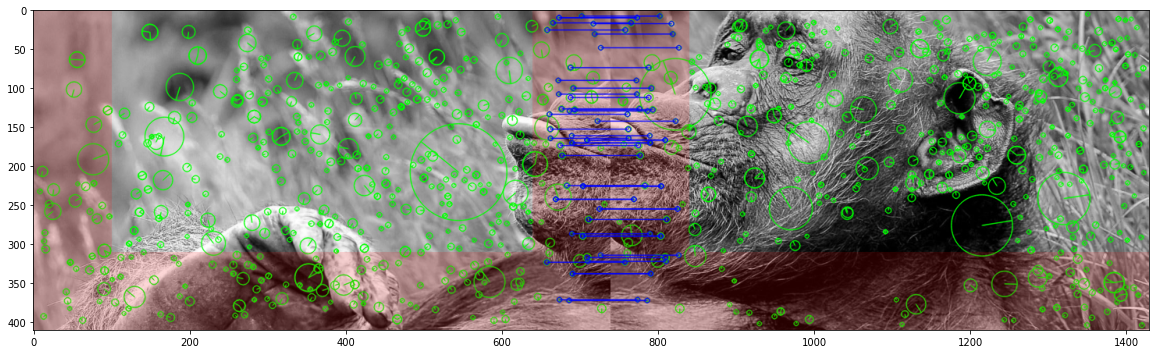

In [18]:
def show_match(sift_data, split1, split2):
    (y1, x1), (y2, x2) = split1.shape[:2], split2.shape[:2]
    if y1 > y2:
        padimg = np.full_like([], 255, shape=(y1, x2, 3), dtype=uint8)
        padimg[0:y2] = split2
        split2 = padimg
    elif y2 > y1:
        padimg = np.full_like([], 255, shape=(y2, x1, 3), dtype=uint8)
        padimg[0:y1] = split1
        split1 = padimg

    [(kp1, des1), (kp2, des2)] = sift_data
    bf = cv.BFMatcher()
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    matches = [[m] for m, n in matches if m.distance < 0.4 * n.distance]
    # can use mask on split region
    res = cv.drawMatchesKnn(
        split1,
        kp1,
        split2,
        kp2,
        matches,
        None,
        matchColor = (0, 0, 255),
        # singlePointColor = (255, 255, 255),
        flags = cv.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    plt.figure(figsize=(20,10))
    plt.imshow(res)

[split01, split02] = splits[0][1:3]
show_match(sift_data, split01, split02)

Show Affine Invariance

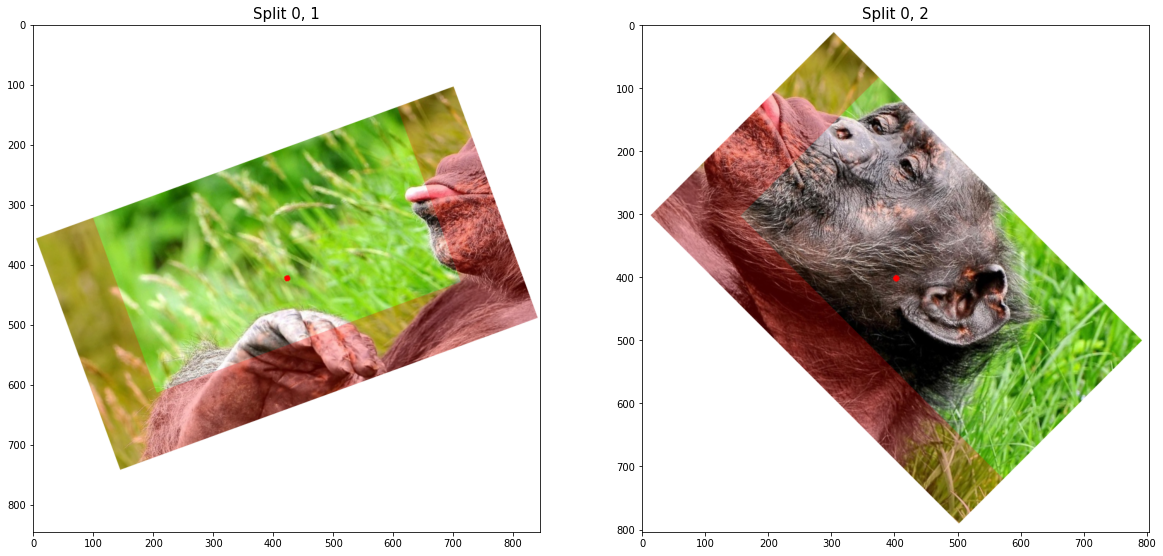

In [19]:
def rotation(img, theta):
    (y, x) = img.shape[:2]
    cx, cy = x / 2.0, y / 2.0
    img = cv.circle(img, (int(cx), int(cy)), 5, (255,0,0), -1)
    #   pad before transform
    #   Take dist between center and corner.
    #   Then take difference between dist and center
    px = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cx)
    py = math.ceil(math.sqrt(cx ** 2 + cy ** 2)) - int(cy)
    shape = tuple(map(lambda i, j: (i + 2 * j), img.shape, (py, px, 0)))
    outimg = np.full_like([], 255, shape=shape, dtype=uint8)
    outimg[py:-py:, px:-px] = img

    (y, x) = outimg.shape[:2]
    c = (x // 2, y // 2)

    T = cv.getRotationMatrix2D(c, theta, 1.0)
    img = cv.warpAffine(outimg, T, (x, y), borderValue=(255,255,255))
    return img
    # plt.figure(figsize=(10,10))
    # plt.imshow(outimg)

splits.restore()
splits.draw_splits(mod=True, _rects=True, _alpha=0.25)
splits.apply(
    rotation,
    range(0,1),
    range(2,3),
    theta = -45,
)
splits.apply(
    rotation,
    range(0,1),
    range(1,2),
    theta = 20,
)
splits.show(range(0,1), range(1,3),)

In [20]:
sift_data = splits.apply(
    apply_SIFT,
    **params,
    min_s=3
)

# compare both image heights and white pad based off of diffs
[split01, split02] = splits[0][1:3]
show_match(sift_data, split01, split02)

ValueError: could not broadcast input array from shape (804,804,3) into shape (804,804)